In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.xkcd()
# rcParams['font.family'] = ['xkcd', 'Comic Neue', 'Comic Mono']

import xarray as xr
import random 
import os 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.transect import add_transects_with_aligned_boxes,make_mask_box

settings_path = 'settings/sam3d.yaml'

# import matplotlib.cm as cm
# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
# import glob
# import intake
# import dask
# import functools
# import pandas as pd
# dask.config.set({"array.slicing.split_large_chunks": True}) 
import cartopy.crs as ccrs
import cartopy.feature as cf
# import cmocean
# # !pip install easygems
# import tqdm
# import scipy
# import datetime as dt 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
# from funcs import *


hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 3.64 seconds


In [2]:
def add_gridlines(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'gray'}
    gl.xlocator = plt.MaxNLocator(integer=True)
    gl.ylocator = plt.MaxNLocator(integer=True)

In [3]:
test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
z_targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
print("z_shear index", z_indices)
print("len z_tropo", len(z_tropo))

z_shear index [6, 22, 29, 37, 45]
len z_tropo 52


In [4]:
duration_min = 6 #12
surfmaxkm2_min = 25000 #50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    ### HIGH PROPAGATION ####
    storms = storms.where(storms.INT_velocityAvg > 3, drop=True)  # 1min
    storms = storms.where(storms.INT_distance > 500, drop=True)  # 1min

    # ### LOW PROPAGATION ####
    # storms = storms.where(storms.INT_velocityAvg <= 3, drop=True)  # 1min
    # storms = storms.where(storms.INT_distance <= 500, drop=True)  # 1min
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

In [5]:
duration_min = 6 #10
surfmaxkm2_min = 10000 #50000 #20000 has 10k elements while 10000 has 29k 
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
storms = xr.open_dataset(st.file_storms)

def filter_storm(ft, region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min=None, vavg_max=None): #, start_date = 
    if vavg_max is None and vavg_min is None : 
        pass
    elif vavg_max is None :
        ft =  ft.where(ft.INT_velocityAvg > vavg_min, drop=True)
    elif vavg_min is None :
        ft = ft.where(ft.INT_velocityAvg < vavg_max, drop=True)
    elif vavg_min is not None and vavg_max is not None : 
        print("you don't understand what you're doing my dear")
    # Apply latitude and longitude constraints
    ft = ft.where((ft.INT_latmin >= region_latmin) & (ft.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        ft = ft.where((ft.INT_lonmin >= region_lonmin) & (ft.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        ft = ft.where((ft.INT_lonmin >= 360+region_lonmin) | (ft.INT_lonmin <= region_lonmax), drop=True)
    return ft


ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_99"] = np.max(ft.LC_instant_prec_99th, axis=1)
ft["INT_max_accumulated_95"] = np.max(ft.LC_accumulated_prec_95th, axis=1)
ft["INT_max_instant_95"] = np.max(ft.LC_instant_prec_95th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_total_prec, axis=1)

ft = ft.dropna(dim='DCS_number', subset=['INT_velocityAvg', 'INT_sum_total', 'INT_max_instant_99', 'INT_max_accumulated_90'])

xt =  ft.where((ft.INT_max_accumulated_95)+2*(ft.INT_max_instant_99)>200, drop=True)

## Dev metpy hmix and theta

In [6]:
import metpy.calc as mpcalc
from metpy.calc import virtual_potential_temperature, density
from metpy.units import units

In [ ]:
iDCS = random.choice(xt.DCS_number.values) #282330
start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(xt, iDCS)
full_extent, full_slice_lon, full_slice_lat = st.get_full_extent_slice(lons[:i_smax+1], lats[:i_smax+1], large_scale_frame_size = 0.5)
times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
t = len(times_3d_conv)

le_dico_long = {"latitude": full_slice_lat, "longitude": full_slice_lon}
le_dico_court = {"lat": full_slice_lat, "lon": full_slice_lon}

i=1
i_t = times_3d[i]
sel_dict = le_dico_court

In [8]:
def load_theta_v_and_pho(i_t, z_idx, sel_dict): 
    """
    z_idx = "all", "L'altitude de la troposphère" or int idx
    """
    PP = hdlr.load_var(cs, "PP", i_t, z_idx = z_idx, sel_dict = sel_dict).isel(time=0)
    TABS = hdlr.load_var(cs, "TABS", i_t, z_idx = z_idx, sel_dict = sel_dict).isel(time=0)
    QV = hdlr.load_var(cs, "QV", i_t, z_idx = z_idx, sel_dict = sel_dict).isel(time=0)

    pressure = (PP.PP + 100*PP.p) * units.Pa
    temperature = TABS.TABS*units.K 
    qv = QV.QV * units('g/kg') 
    theta_v = virtual_potential_temperature(pressure, temperature, qv)
    pho = density(pressure, temperature, qv)
    return theta_v, pho

def density_average(X, pho, z_sfc_idx, z_idx, z_all=z_all):
    arr_d_z = np.diff(z_all)
    arr_d_z_re = arr_d_z.reshape(arr_d_z.shape + (1,) * (X.ndim - 1))
    numerator = np.sum(
        X[z_sfc_idx:z_idx+1] * pho[z_sfc_idx:z_idx+1] * arr_d_z_re[z_sfc_idx:z_idx+1],
        axis=0
    )
    denominator = np.sum(
        pho[z_sfc_idx:z_idx+1] * arr_d_z_re[z_sfc_idx:z_idx+1],
        axis=0
    )
    return numerator / denominator

def height_mixed_layer(theta_v, pho, z_all = z_all):
    h_mix = np.full_like(theta_v[0], np.nan)
    h_mix_as_z_idx = np.full_like(theta_v[0], 0, dtype = int)
    for z_idx, z in enumerate(z_all[:15]):
        pho_avg_theta_v = density_average(theta_v, pho, 0, z_idx, z_all)
        mask = (theta_v[z_idx+1].values > pho_avg_theta_v.values + 0.2)
        nan_mask = np.isnan(h_mix)
        min_mask = (mask & nan_mask) #since z necessarily ascending
        h_mix[min_mask] = z
        h_mix_as_z_idx[min_mask] = z_idx
    return h_mix, h_mix_as_z_idx

def theta_v_mixed_layer(i_t, sel_dict):
    theta_v, pho = load_theta_v_and_pho(i_t, "La couche limite de mélange", sel_dict)
    theta_v_mix = np.full_like(theta_v[0], np.nan)
    h_mix, h_mix_as_z_idx = height_mixed_layer(theta_v, pho)
    shape = h_mix.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            z_idx = h_mix_as_z_idx[i, j]
            theta_v_mix[i, j] = density_average(
                theta_v[:, i, j], pho[:, i, j], 0, z_idx
            )
    return theta_v_mix


In [9]:

theta_v, pho = load_theta_v_and_pho(i_t, "La couche limite de mélange", sel_dict)
h_mix, h_mix_as_z_idx = height_mixed_layer(theta_v, pho)
theta_v_mix = theta_v_mixed_layer(i_t, le_dico_court)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

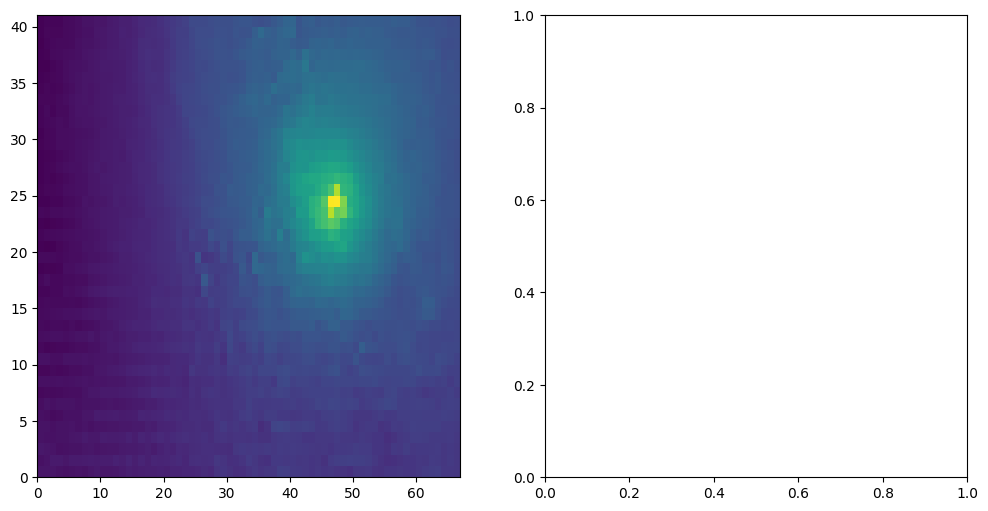

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].pcolormesh(theta_v_mix)
plt.colorbar()
axs[1].pcolormesh(h_mix)
plt.colorbar()

In [ ]:
def height_surface_inversion(temperature, z_all = z_all):
    h_inv_sfc = np.full_like(temperature[0], np.nan)
    len_z = temperature.shape[0] ## assume z is first coordinate
    z_levels = z_all[:len_z+1] ## assume temperature z_field always starts from the ground 
    dz = np.diff(z_levels)[:, np.newaxis, np.newaxis]  # Shape: (z-1, 1, 1)
    dT_dz = np.diff(temperature, axis=0) / dz 

    for z_idx in range(dT_dz.shape[0]):
        mask = (dT_dz < 0)
        nan_mask = np.isnan(h_inv_sfc)
        min_mask = mask & nan_mask
        h_inv_sfc[min_mask] = z_levels[z_idx]

    return h_inv_sfc



## Anim plot below

In [ ]:
import warnings
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.colors as mcolors
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

lolmdr=0
while lolmdr<20:
    lolmdr+=1
    start = 0
    while start <=245 :
        iDCS = random.choice(xt.DCS_number.values)
        # iDCS = 282909
        large_scale_frame_size = 2
        start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(xt, iDCS)
        full_extent, full_slice_lon, full_slice_lat = st.get_full_extent_slice(lons[:i_smax+1], lats[:i_smax+1], large_scale_frame_size = large_scale_frame_size)
        times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
        t = len(times_3d_conv)

    # Initialize constants and variables
    i_z_plot = 15
    w_minmax = 16  # Adjusted to cover more levels
    w_step = 1  # Step size for 'w' contours
    w_start = 0.8
    slice_lat, slice_lon, extent = full_slice_lat, full_slice_lon, full_extent
    projection = ccrs.PlateCarree(central_longitude=0)
    figsize_ratio = 4 / large_scale_frame_size
    prec_cmap = plt.get_cmap("nipy_spectral")
    colors = [(1, 1, 1, 0), (0.0, 0.0, 0.0, 0.3), (0.5, 0.5, 0.5, 1)]
    cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)

    # Instantiate the plot
    fig, ax = plt.subplots(figsize=(figsize_ratio * (extent[1] - extent[0]), figsize_ratio * (extent[3] - extent[2])), subplot_kw={"projection": projection})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    add_gridlines(ax)  # Ensure this function is defined or imported

    # Prepare selection dictionaries
    le_dico_long = {"latitude": slice_lat, "longitude": slice_lon}
    le_dico_court = {"lat": slice_lat, "lon": slice_lon}

    # Load initial data for the first frame
    i = 0
    time_current = times[i]

    seg = hdlr.load_seg(time_current, sel_dict=le_dico_long)[0]
    prec = hdlr.load_var(cs, "Prec", time_current, sel_dict=le_dico_court)
    # prec_masked = np.ma.masked_less_equal(prec, 3)

    # Load PW data
    pw = hdlr.load_var(cs, "PW", time_current, sel_dict=le_dico_court)[0]

    lat = seg['latitude'].values
    lon = seg['longitude'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    U10m = hdlr.load_var(cs, "U10m", time_current, sel_dict=le_dico_court)[0]
    v10m = hdlr.load_var(cs, "V10m", time_current, sel_dict=le_dico_court)[0]
    R = 6371000
    lat_rad = np.radians(lat_grid)
    lon_rad = np.radians(lon_grid)
    dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)  # Spacing in x-direction (longitude)
    dy = R * np.gradient(lat_rad, axis=0)     
    dU_dx = np.gradient(U10m, axis=1) / dx  # Partial derivative of U with respect to x (longitude)
    dV_dy = np.gradient(v10m, axis=0) / dy  # Partial derivative of V with respect to y (latitude)
    surf_wind_div = dU_dx + dV_dy

    # Plot PW data
    # pw_norm = mcolors.Normalize(vmin=40, vmax=65)
    # pw_cmap = plt.get_cmap('RdBu')
    
    # Plot winddiv data
    # wd_cmap = plt.get_cmap('RdBu')
    # wd_norm = mcolors.Normalize(vmin = -0.003, vmax= 0.003)
    # im_winddiv = ax.pcolormesh(lon_grid, lat_grid, surf_wind_div, cmap=wd_cmap, norm=wd_norm, alpha=1.0)
    # Add colorbar for winddiv
    # cbar_pw = plt.colorbar(im_winddiv, ax=ax, orientation='vertical', pad=0.01, aspect=40, shrink=0.8, label='Winddiv')

    # Initialize cloud mask plot
    nan_mask = np.isnan(seg)
    output = np.full_like(seg, 0.5, dtype=float)
    output[nan_mask] = 0
    output[seg == iDCS] = 1  # Replace iDCS with your actual data
    # im_seg = ax.pcolormesh(lon_grid, lat_grid, output, cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1), alpha=0.1)
    contour_output_main = ax.contour(lon_grid, lat_grid, output, levels=[0.75], colors='black', linewidths=[2.0], linestyles='solid')
    contour_output_side = ax.contour(lon_grid, lat_grid, output, levels=[0.25], colors='black', linewidths=[0.4], linestyles='solid')


    # Initialize precipitation contours
    prec_levels = [1, 3, 10, 20, 30, 40, 50]
    contour_prec = ax.contour(lon_grid, lat_grid, prec.values, levels=prec_levels, colors='black', linewidths=0.5, linestyles='dashed')

    max_prec_inst_99 = np.round(xt.sel(DCS_number=iDCS).INT_max_instant_99).values
    xprec = np.ma.masked_less_equal(prec, max_prec_inst_99)
    my_DCS = output==1
    xprec.mask[~my_DCS]=True
    extreme_prec_indices = np.where(xprec.mask == False)
    extreme_lon = lon_grid[extreme_prec_indices]
    extreme_lat = lat_grid[extreme_prec_indices]
    im_xprec = ax.scatter(extreme_lon,  extreme_lat, c='k', marker='x', s=150)

    # Initialize arrow propagation maturation
    # lon_smax, lat_smax = lons[i_smax], lats[i_smax]
    # lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
    # quiv = ax.quiver( lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')

    # Load initial data for first 3D plot
    first_time_3d = times_3d[0]
    u = hdlr.load_var(cs, "U", first_time_3d, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).U[0]
    v = hdlr.load_var(cs, "V", first_time_3d, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).V[0]
    w = hdlr.load_var(cs, "W", first_time_3d, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).W[0]

    fake_u = xr.DataArray(np.full_like(u, np.nan), coords=u.coords, dims=u.dims)
    fake_v = xr.DataArray(np.full_like(v, np.nan), coords=v.coords, dims=v.dims)
    fake_w = xr.DataArray(np.full_like(w, np.nan), coords=w.coords, dims=w.dims)
    #w levels
    positive_levels = np.arange(w_start, w_minmax + w_step, w_step)
    negative_levels = -positive_levels[::-1]

    contour_w_positive = ax.contour(lon_grid, lat_grid, w.values[i_z_plot], levels=positive_levels, colors='red', linewidths=0.5)
    contour_w_negative = ax.contour( lon_grid, lat_grid, w.values[i_z_plot], levels=negative_levels, colors='blue', linewidths=0.5)

    # Plot wind vectors 'U' and 'V'
    new_lon = np.linspace(lon.min(), lon.max(), len(lon))
    new_lat = np.linspace(lat.min(), lat.max(), len(lat))
    u_clean = u.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  u.interp(lon=new_lon, lat=new_lat)[0] #For now its low level shear instead of wind
    v_clean = v.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  v.interp(lon=new_lon, lat=new_lat)[0]
    lon_grid_regular, lat_grid_regular = np.meshgrid(new_lon, new_lat)
    horizontal_wind_magnitude = np.sqrt(u_clean.values**2 + v_clean.values**2)
    strm = ax.streamplot(lon_grid_regular, lat_grid_regular, u_clean.values, v_clean.values, color=horizontal_wind_magnitude, cmap="viridis", linewidth=0.5, density=1.5)
    
    ## Rochetin stuff in 3d 
    # Load 
    theta_v_mix = theta_v_mixed_layer(first_time_3d, le_dico_court)
    fake_theta_v_mix = np.full_like(theta_v_mix, np.nan)

    ## Plot something
    theta_v_mix_cmap = plt.get_cmap('RdBu_r')
    theta_v_mix_norm = mcolors.Normalize(vmin = 298, vmax= 303)

    im_theta_v = ax.pcolormesh(lon_grid, lat_grid, theta_v_mix, cmap=theta_v_mix_cmap, norm = theta_v_mix_norm, alpha=1.0)
    cbar_theta_v = plt.colorbar(im_theta_v, ax=ax, orientation='vertical', pad=0.01, aspect=40, shrink=0.8, label='Theta_v mixed layer')

    ## Title stuff
    age_to_smax = int(100 * np.round((time_current - st.settings["TIME_RANGE"][0] - start) /(time_smax - start), 2))
    title = ax.set_title(f"DCS_number: {iDCS}\nAge to smax: {age_to_smax}%")

    def animate(i):
        global im_theta_v, im_xprec, contour_output_main, contour_output_side, contour_prec, contour_w_positive, contour_w_negative, strm  # Declare as global to modify them
        print(i)
        time_current = times[i]

        # Load data for the current frame
        seg = hdlr.load_seg(time_current, sel_dict=le_dico_long)[0]
        prec = hdlr.load_var(cs, "Prec", time_current, sel_dict=le_dico_court)
        # prec_masked = np.ma.masked_less_equal(prec, 3)
        # pw = hdlr.load_var(cs, "PW", time_current, sel_dict=le_dico_court)[0]

        # Remove and update previous precipitation contours
        for coll in contour_prec.collections:
            coll.remove()
        contour_prec = ax.contour(lon_grid, lat_grid, prec.values, levels=prec_levels, colors='black', linewidths=1, linestyles='dotted')

        # ## plot winddiv
        # U10m = hdlr.load_var(cs, "U10m", time_current, sel_dict=le_dico_court)[0]
        # v10m = hdlr.load_var(cs, "V10m", time_current, sel_dict=le_dico_court)[0]
        # R = 6371000
        # lat_rad = np.radians(lat_grid)
        # lon_rad = np.radians(lon_grid)
        # dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)  # Spacing in x-direction (longitude)
        # dy = R * np.gradient(lat_rad, axis=0)     
        # dU_dx = np.gradient(U10m, axis=1) / dx  # Partial derivative of U with respect to x (longitude)
        # dV_dy = np.gradient(v10m, axis=0 ) / dy  # Partial derivative of V with respect to y (latitude)
        # surf_wind_div = dU_dx + dV_dy

        # im_winddiv = ax.pcolormesh(lon_grid, lat_grid, surf_wind_div, cmap=wd_cmap, norm=wd_norm, alpha=1.0)

        # Update cloud mask plot
        nan_mask = np.isnan(seg)
        output = np.full_like(seg, 0.5, dtype=float)
        output[nan_mask] = 0
        output[seg == iDCS] = 1
        # im_seg.set_array(output.ravel())

        for coll in contour_output_main.collections:
            coll.remove()
        contour_output_main = ax.contour(lon_grid, lat_grid, output, levels=[0.75], colors='black', linewidths=[2.0], linestyles='solid')

        for coll in contour_output_side.collections:
            coll.remove()
        contour_output_side = ax.contour(lon_grid, lat_grid, output, levels=[0.25], colors='black', linewidths=[0.4], linestyles='solid')


        if im_xprec:
            im_xprec.remove() 
        # xprec
        max_prec_inst_99 = np.round(xt.sel(DCS_number=iDCS).INT_max_instant_99).values
        xprec = np.ma.masked_less_equal(prec, max_prec_inst_99)
        my_DCS = output==1
        xprec.mask[~my_DCS]=True
        extreme_prec_indices = np.where(xprec.mask == False)
        # print(extreme_prec_indices)
        extreme_lon = lon_grid[extreme_prec_indices]
        extreme_lat = lat_grid[extreme_prec_indices]
        im_xprec = ax.scatter(extreme_lon,  extreme_lat, c='k', marker='x', s=150)

        if time_current in times_3d:
            u = hdlr.load_var(cs, "U", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).U[0]
            v = hdlr.load_var(cs, "V", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).V[0]
            w = hdlr.load_var(cs, "W", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).W[0]
            theta_v_mix = theta_v_mixed_layer(time_current, le_dico_court)
        else:
            u,v,w = fake_u, fake_v, fake_w
            theta_v_mix = fake_theta_v_mix

        if im_theta_v:
            im_theta_v.remove()
        # PLot Theta_v
        im_theta_v = ax.pcolormesh(lon_grid, lat_grid, theta_v_mix, cmap=theta_v_mix_cmap, norm = theta_v_mix_norm, alpha=1.0)
        # cbar_theta_v = plt.colorbar(im_theta_v, ax=ax, orientation='vertical', pad=0.01, aspect=40, shrink=0.8, label='Theta_v')

        for art in ax.get_children():
            if isinstance(art, matplotlib.patches.FancyArrowPatch):
                art.remove()

        if strm is not None:
            strm.lines.remove()

        if contour_w_positive is not None:
            for coll in contour_w_positive.collections:
                coll.remove()
        if contour_w_negative is not None:
            for coll in contour_w_negative.collections:
                coll.remove()

        if time_current in times_3d:
            contour_w_positive = ax.contour(lon_grid, lat_grid, w.values[i_z_plot], levels=positive_levels, colors='red', linewidths=0.5)
            contour_w_negative = ax.contour(lon_grid, lat_grid, w.values[i_z_plot], levels=negative_levels, colors='blue', linewidths=0.5)
        else:
            contour_w_positive = None
            contour_w_negative = None

        # Update streamplot
        new_lon = np.linspace(lon.min(), lon.max(), len(lon))
        new_lat = np.linspace(lat.min(), lat.max(), len(lat))
        u_clean = u.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  u.interp(lon=new_lon, lat=new_lat)[0]
        v_clean = v.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  v.interp(lon=new_lon, lat=new_lat)[0]
        lon_grid_regular, lat_grid_regular = np.meshgrid(new_lon, new_lat)
        horizontal_wind_magnitude = np.sqrt(u_clean.values**2 + v_clean.values**2)
        strm = ax.streamplot(lon_grid_regular, lat_grid_regular, u_clean.values, v_clean.values, color=horizontal_wind_magnitude, cmap="viridis", linewidth=0.5, density=1.5)
 
        # Update title
        age_to_smax = int(100 * np.round((time_current - st.settings["TIME_RANGE"][0] - start) /(time_smax - start), 2))
        max_prec_acc_95 = np.round(xt.sel(DCS_number = iDCS).INT_max_accumulated_95).values
        max_prec_inst_99 = np.round(xt.sel(DCS_number = iDCS).INT_max_instant_99).values
        title.set_text(f"DCS_number: {iDCS}\nAge to smax: {age_to_smax}%" +f" ; w(z={int(z_tropo[i_z_plot])}m)"+"\n"+f"Max Acc Prec 95th {max_prec_acc_95} mm/h and Max Inst Prec 99th {max_prec_inst_99} mm/h")
 
        # Return the updated artists
        artists = [im_theta_v, im_xprec, *contour_output_main.collections, *contour_output_side.collections, title, *contour_prec.collections]

        if time_current in times_3d:
            artists.extend(contour_w_positive.collections)
            artists.extend(contour_w_negative.collections)
            artists.extend([strm.lines, strm.arrows])

        return artists

    ani = FuncAnimation(
                        fig, animate, 
                        frames= len(times[:i_smax+1]),
                        interval=1000
                        )
    writer = FFMpegWriter(fps=1, codec="libx264")
    ani.save(f"/scratchx/mcarenso/shear/extremes_animation_v5/DCS_{iDCS}.mp4", writer=writer)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
0
1
2
3
4
5
6
7
8
9
10
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
0
1
2
3
4
5
6
7
8
9
10
0
0
1
2
3
4
5
6
7
8
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
